# SUPERVISED CLASSIFICATION MODELLING

## IMPORTING PACKAGES

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns

from sklearn.model_selection import train_test_split

from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.pipeline import Pipeline

from sklearn.model_selection import GridSearchCV

from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix

import scikitplot as skplt

#To increase autocomplete response speed
%config IPCompleter.greedy=True

#Disabling scientific notation
pd.options.display.float_format = '{:.2f}'.format

#Disabling warnings
import warnings
warnings.filterwarnings("ignore")

C:\Users\pedro\miniconda3\envs\pf_leadscoring\lib\site-packages\xgboost\compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


## DATA IMPORTATION

Project path.

In [3]:
project_path = (r'C:\Users\pedro\PEDRO\DS\Portfolio\LEAD_SCORING').replace('\\','/')

Names of data files.

In [4]:
x_name = 'x_preselected.pickle'
y_name = 'y_preselected.pickle'

Data importation.

In [5]:
x = pd.read_pickle(project_path + '/02_Data/03_Work/' + x_name)
y = pd.read_pickle(project_path + '/02_Data/03_Work/' + y_name)

## MODELLING

In this section different combinations of algorithms/hyperparameters will be tested to find those with the best performance.

### Reserving validation dataset

In [18]:
train_x,val_x,train_y,val_y = train_test_split(x,y,test_size=0.3)

### Creating the pipe and the dictionary of algorithms, parameters and values to be tested

In [7]:
pipe = Pipeline([('algorithm',LogisticRegression())])

grid = [{'algorithm': [LogisticRegression(solver='saga', n_jobs=-1, max_iter=1000)],
         'algorithm__penalty': ['elasticnet', 'l1', 'l2', 'none'],
         'algorithm__C': list(np.round(np.arange(0,1,0.1),1))},
        
        {'algorithm': [XGBClassifier(use_label_encoder=False, verbosity=0, n_jobs=-1)],
         'algorithm__learning_rate': [0.01,0.05,0.1],
         'algorithm__max_depth': [5,10,20],
         'algorithm__reg_alpha': [0,0.1,0.5,1],
         'algorithm__reg_lambda': [0.01,0.1,1],
         'algorithm__n_estimators': [100,500,1000]},
        
        {'algorithm': [HistGradientBoostingClassifier(scoring='roc_auc',verbose=0)],
         'algorithm__learning_rate': [0.01,0.05,0.1],
         'algorithm__max_iter': [100,500],
         'algorithm__max_depth': [5,10,20],
         'algorithm__min_samples_leaf': [100,200,500],
         'algorithm__l2_regularization': [0.25,0.5,0.75,1]}
       ]

### Hyperparameter optimization

#### Using grid search

In [ ]:
grid_search = GridSearchCV(estimator= pipe, 
                           param_grid = grid, 
                           cv = 5, 
                           scoring = 'roc_auc',
                           verbose = 3,
                           n_jobs = -1)

model = grid_search.fit(train_x,train_y)

pd.DataFrame(grid_search.cv_results_).sort_values(by = 'rank_test_score')

As can be seen in the above dataframe, algorithms that are obtaining the best roc auc scores are those based on Gradient Boosted Machines (XGBoost, LightGBM). However, there does not seem to be much difference with respect to the scores obtained in the best parameterisations of logistic regression algorithms. 

On the other hand, note that scores obtained in the tested algorithms/parametrisations remains stable during cross-validation process, which is a good indicator of the stability of the model predictions.

The best parameterisation of each type of algorithm (XGBoost, LightGBM, Logistic Regression) will be selected in order to analyse in detail whether there are significant differences in their performance that could lead to the selection of the final algorithm architecture to be used.

Dataframe of tested Logistic Regression model parametrisations:

In [ ]:
df_lr = pd.DataFrame(grid_search.cv_results_)[['params','mean_test_score','std_test_score','rank_test_score']].loc[
            pd.concat([pd.DataFrame(grid_search.cv_results_)[['params','mean_test_score','std_test_score','rank_test_score']],
               pd.DataFrame(grid_search.cv_results_)[['param_algorithm']].param_algorithm.transform(lambda x: type(x).__name__)],
              axis=1).param_algorithm.str.contains('LogisticRegression')].sort_values(by='rank_test_score')
df_lr.head(5)

Best Logistic Regression model according to roc auc metric (training dataset):

In [ ]:
df_best_lr_model = pd.concat([pd.DataFrame({'algorithm':[df_lr.iloc[0].params['algorithm']]}),
                   pd.DataFrame.from_dict(df_lr.iloc[0].params,orient='index').iloc[1:].T,
                   pd.DataFrame(df_lr.iloc[0,1:]).T.reset_index()],axis=1).T
df_best_lr_model

In [8]:
best_lr_model = LogisticRegression(solver='saga',
                                   C=0.9,
                                   penalty='l2',
                                   max_iter=1000, 
                                   n_jobs=-1)
best_lr_model.fit(train_x,train_y)

LogisticRegression(C=0.9, max_iter=1000, n_jobs=-1, solver='saga')

DataFrame of tested XGBoost model parametrisations:

In [ ]:
df_xgb = pd.DataFrame(grid_search.cv_results_)[['params','mean_test_score','std_test_score','rank_test_score']].loc[
            pd.concat([pd.DataFrame(grid_search.cv_results_)[['params','mean_test_score','std_test_score','rank_test_score']],
               pd.DataFrame(grid_search.cv_results_)[['param_algorithm']].param_algorithm.transform(lambda x: type(x).__name__)],
              axis=1).param_algorithm.str.contains('XGB')].sort_values(by='rank_test_score')
df_xgb.head(5)

Best XGBoost model according to roc auc metric (training dataset):

In [ ]:
df_best_xgb_model = pd.concat([pd.DataFrame({'algorithm':[df_xgb.iloc[0].params['algorithm']]}),
                   pd.DataFrame.from_dict(df_xgb.iloc[0].params,orient='index').iloc[1:].T,
                   pd.DataFrame(df_xgb.iloc[0,1:]).T.reset_index()],axis=1).T
df_best_xgb_model

In [20]:
best_xgb_model = XGBClassifier(learning_rate = 0.1,
                               max_depth = 5,
                               n_estimators = 100,
                               reg_alpha = 1,
                               reg_lambda = 1,
                               use_label_encoder=False, 
                               verbosity=0, 
                               n_jobs=-1)

best_xgb_model.fit(train_x,train_y)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              gamma=0, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.1, max_delta_step=0,
              max_depth=5, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=-1,
              num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=1, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', use_label_encoder=False,
              validate_parameters=1, verbosity=0)

DataFrame of tested LightGBM model parametrisations:

In [ ]:
df_lgbm = pd.DataFrame(grid_search.cv_results_)[['params','mean_test_score','std_test_score','rank_test_score']].loc[
            pd.concat([pd.DataFrame(grid_search.cv_results_)[['params','mean_test_score','std_test_score','rank_test_score']],
               pd.DataFrame(grid_search.cv_results_)[['param_algorithm']].param_algorithm.transform(lambda x: type(x).__name__)],
              axis=1).param_algorithm.str.contains('Hist')].sort_values(by='rank_test_score')
df_lgbm.head(5)

Best LightGBM model according to roc auc metric (training dataset):

In [ ]:
df_best_lgbm_model = pd.concat([pd.DataFrame({'algorithm':[df_lgbm.iloc[0].params['algorithm']]}),
                   pd.DataFrame.from_dict(df_lgbm.iloc[0].params,orient='index').iloc[1:].T,
                   pd.DataFrame(df_lgbm.iloc[0,1:]).T.reset_index()],axis=1).T

In [21]:
best_lgb_model = HistGradientBoostingClassifier(learning_rate = 0.1,
                                                 min_samples_leaf = 100,
                                                 max_iter = 100,
                                                 max_depth = 5,
                                                 l2_regularization = 0.25,
                                                 verbose=0)
best_lgb_model.fit(train_x,train_y)

HistGradientBoostingClassifier(l2_regularization=0.25, max_depth=5,
                               min_samples_leaf=100)

## MODEL EVALUATION

### LightGBM best model

Predicting on validation dataset:

In [37]:
# pred_lgbm = model.best_estimator_.predict_proba(val_x)[:, 1]
pred_lgbm = best_lgb_model.predict_proba(val_x)[:,1]

Evaluating on validation dataset

In [38]:
roc_auc_score(val_y, pred_lgbm)

0.9244150568903045

Examining the model

In [ ]:
# model.best_estimator_

In [40]:
# model.best_estimator_.named_steps.algorithm.

### XGBoost best model

Predicting on validation dataset:

In [23]:
pred_xgb = best_xgb_model.predict_proba(val_x)[:, 1]

Evaluating on validation dataset

In [24]:
roc_auc_score(val_y, pred_xgb)

0.9261233815689263

Feature importances:

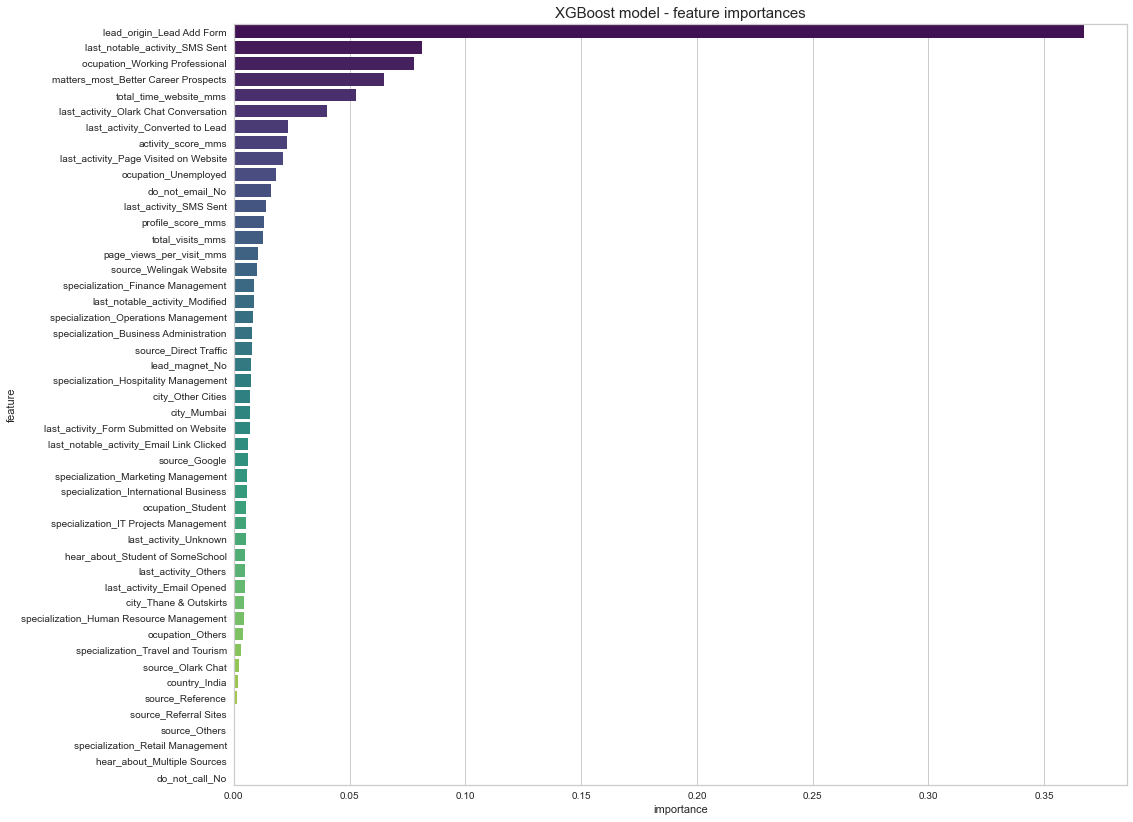

In [30]:
f,ax = plt.subplots(figsize=(16,14))
sns.barplot(data=pd.DataFrame({'feature': x.columns.to_list(),
              'importance': best_xgb_model.feature_importances_}).sort_values(by='importance',ascending=False),
            x='importance',y='feature', palette='viridis')
plt.title(label='XGBoost model - feature importances',fontsize=15);

### Logistic Regression best model

Predicting on validation dataset:

In [19]:
pred_lr = best_lr_model.predict_proba(val_x)[:, 1]

Evaluating on validation dataset

In [29]:
roc_auc_score(val_y, pred_lr)

0.9102227145791502

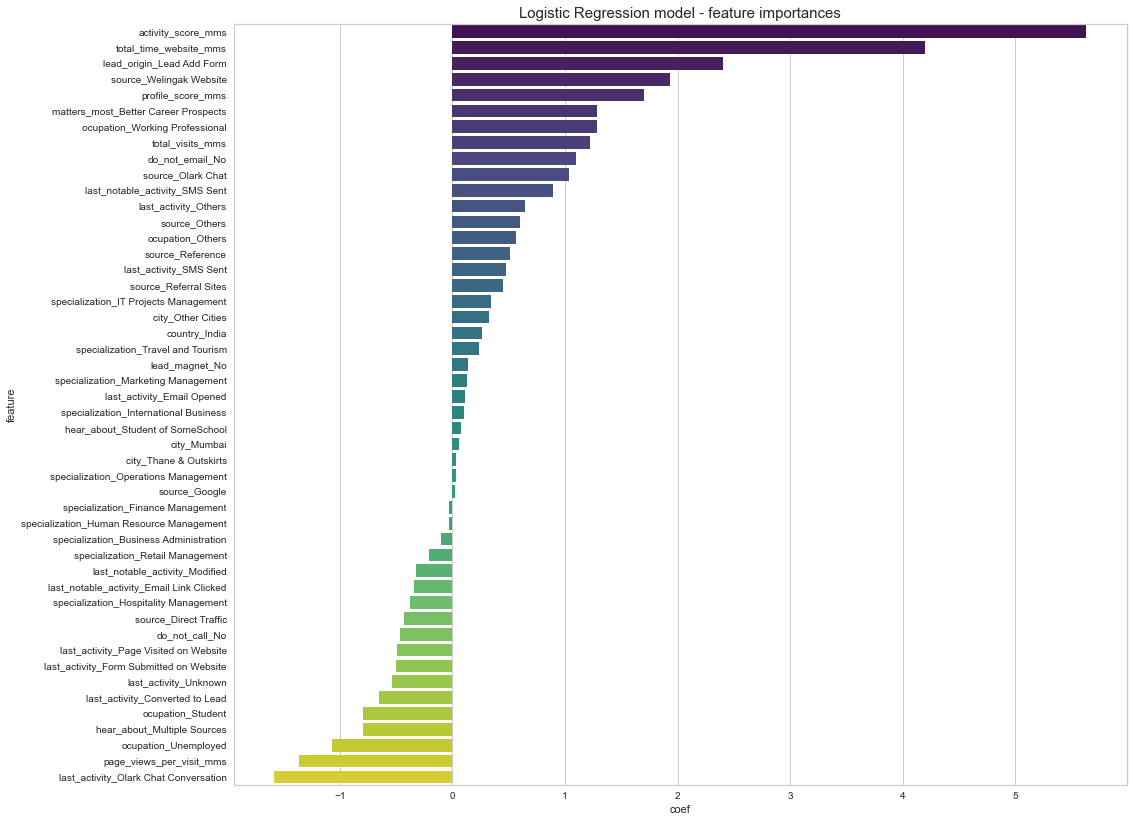

In [27]:
f,ax = plt.subplots(figsize=(16,14))

sns.barplot(data=pd.DataFrame(data=best_lr_model.coef_,
             columns=best_lr_model.feature_names_in_).T.reset_index()\
            .rename(columns={'index':'feature',0:'coef'}).sort_values(by='coef',ascending=False),
            x='coef', y='feature',
            palette='viridis')
plt.title(label='Logistic Regression model - feature importances',fontsize=15);

## MODEL COMPARAISON AND REPORTING

### Gain Chart

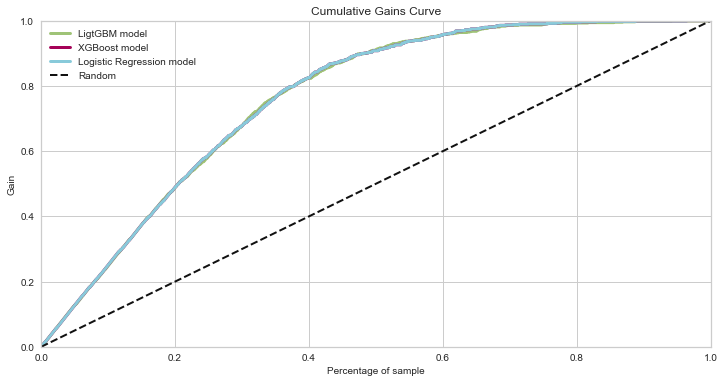

In [41]:
f, ax = plt.subplots(figsize=(12,6))

# LightGBM - Gain chart
skplt.metrics.plot_cumulative_gain(val_y, best_lgb_model.predict_proba(val_x), ax=ax)
del ax.lines[0]
del ax.lines[1]

# XGBoost - Gain chart
skplt.metrics.plot_cumulative_gain(val_y, best_xgb_model.predict_proba(val_x), ax=ax)
del ax.lines[1]
del ax.lines[2]

# Logistic Regression - Gain chart
skplt.metrics.plot_cumulative_gain(val_y, best_xgb_model.predict_proba(val_x), ax=ax)
del ax.lines[2]

plt.legend(labels = ['LigtGBM model', 'XGBoost model', 'Logistic Regression model', 'Random']);

### Lift Chart

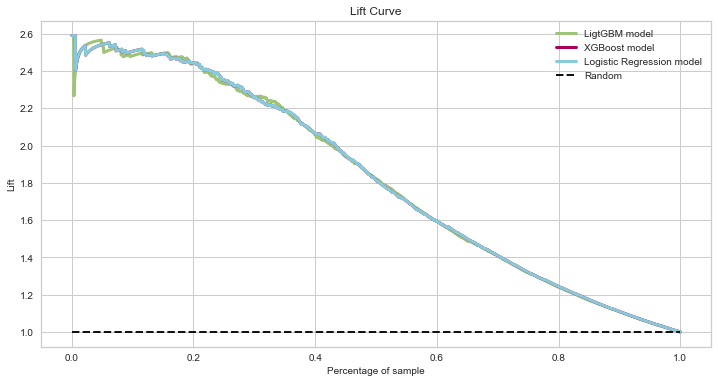

In [42]:
f, ax = plt.subplots(figsize=(12,6))

# LightGBM - Lift chart
skplt.metrics.plot_lift_curve(val_y, best_lgb_model.predict_proba(val_x), ax=ax)
del ax.lines[0]
del ax.lines[1]

# XGBoost - Lift chart
skplt.metrics.plot_lift_curve(val_y, best_xgb_model.predict_proba(val_x), ax=ax)
del ax.lines[1]
del ax.lines[2]

# Logistic Regression - Lift chart
skplt.metrics.plot_lift_curve(val_y, best_xgb_model.predict_proba(val_x), ax=ax)
del ax.lines[2]

plt.legend(labels = ['LigtGBM model', 'XGBoost model', 'Logistic Regression model', 'Random']);

### ROC Chart

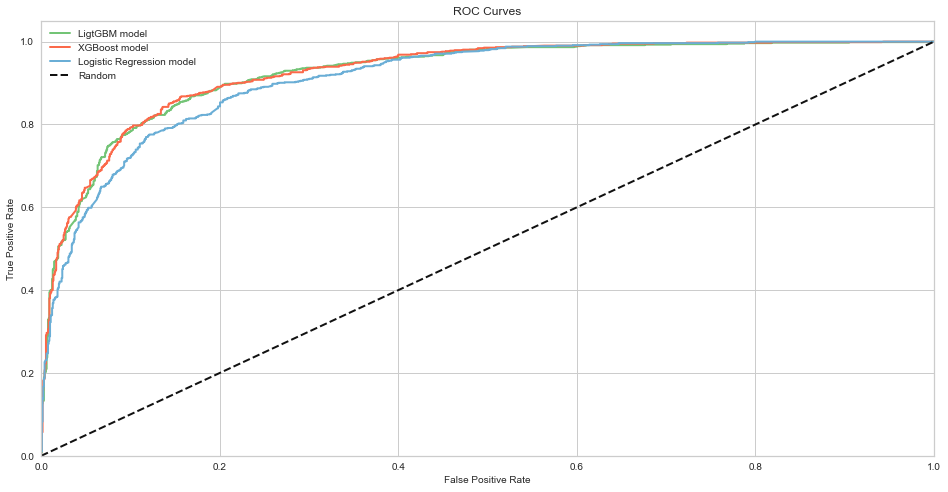

In [43]:
f, ax = plt.subplots(figsize=(16,8))

# LightGBM - ROC chart
skplt.metrics.plot_roc(val_y, best_lgb_model.predict_proba(val_x), ax=ax,
                       plot_micro=False,
                       plot_macro=False,
                       classes_to_plot=1,
                       cmap='Greens')
del ax.lines[1]   

# XGBoost - ROC chart
skplt.metrics.plot_roc(val_y, best_xgb_model.predict_proba(val_x), ax=ax,
                       plot_micro=False,
                       plot_macro=False,
                       classes_to_plot=1,
                       cmap='Reds')
del ax.lines[2]

# Logistic Regression - Cumulative Gains
skplt.metrics.plot_roc(val_y, best_lr_model.predict_proba(val_x), ax=ax,
                       plot_micro=False,
                       plot_macro=False,
                       classes_to_plot=1,
                       cmap='Blues')

plt.legend(labels = ['LigtGBM model', 'XGBoost model', 'Logistic Regression model', 'Random']);

In [ ]:
pd.DataFrame({'Model':['LightGBM','XGBoost','Logistic Regression'],
              'ROC AUC score':[roc_auc_score(val_y,pred_lgbm), 
                               roc_auc_score(val_y,pred_xgb),
                               roc_auc_score(val_y,pred_lr)]})

## SELECTED MODEL - LOGISTIC REGRESSION

As can be seen from the graphs and metrics above, there are no major differences in the performance of the three models compared.
- ROC curves of LightGBM and XGBoost models are almost identical, as is their predictive ability.
- Model based on the logistic regression algorithm has a slightly worse ROC curve than the two tree-based models.

It was decided to implement the logistic regression algorithm for the project due to the following reasons:
1. Its predictive ability is very similar to that obtained with the LightGBM and XGBoost models.
2. It is a much more interpretable model than LightGBM or XGBoost algorithms.
3. It is a simpler model, therefore easier to maintain and quicker to train, re-train and execute.
4. It can be easily migrated to the platforms and software currently used by the company due to its mathematical simplicity.

In [32]:
best_lr_model.get_params()

{'C': 0.9,
 'class_weight': None,
 'dual': False,
 'fit_intercept': True,
 'intercept_scaling': 1,
 'l1_ratio': None,
 'max_iter': 1000,
 'multi_class': 'auto',
 'n_jobs': -1,
 'penalty': 'l2',
 'random_state': None,
 'solver': 'saga',
 'tol': 0.0001,
 'verbose': 0,
 'warm_start': False}

# OPTIMAL DISCRIMINATION THRESHOLD

This section analyses what is the optimal discrimination threshold value that maximises the company's return on investment. In this way, in addition to the scoring, the model developed will indicate for each customer whether it should be subject to commercial actions or whether it is not worth investing resources in managing it.

As reported by the company, its revenue and cost scenario is as follows:
- Product selling price (online course for industry professional): 49.99 \$
- Lead-to-customer average cost: 3.25 $ per converted customer.

To find the optimal value of the discrimination threshold the confusion matrix and a business defined economic impact matrix will be used.


In [14]:
product_price = 49.99
ltc_avg_cost = 3.25

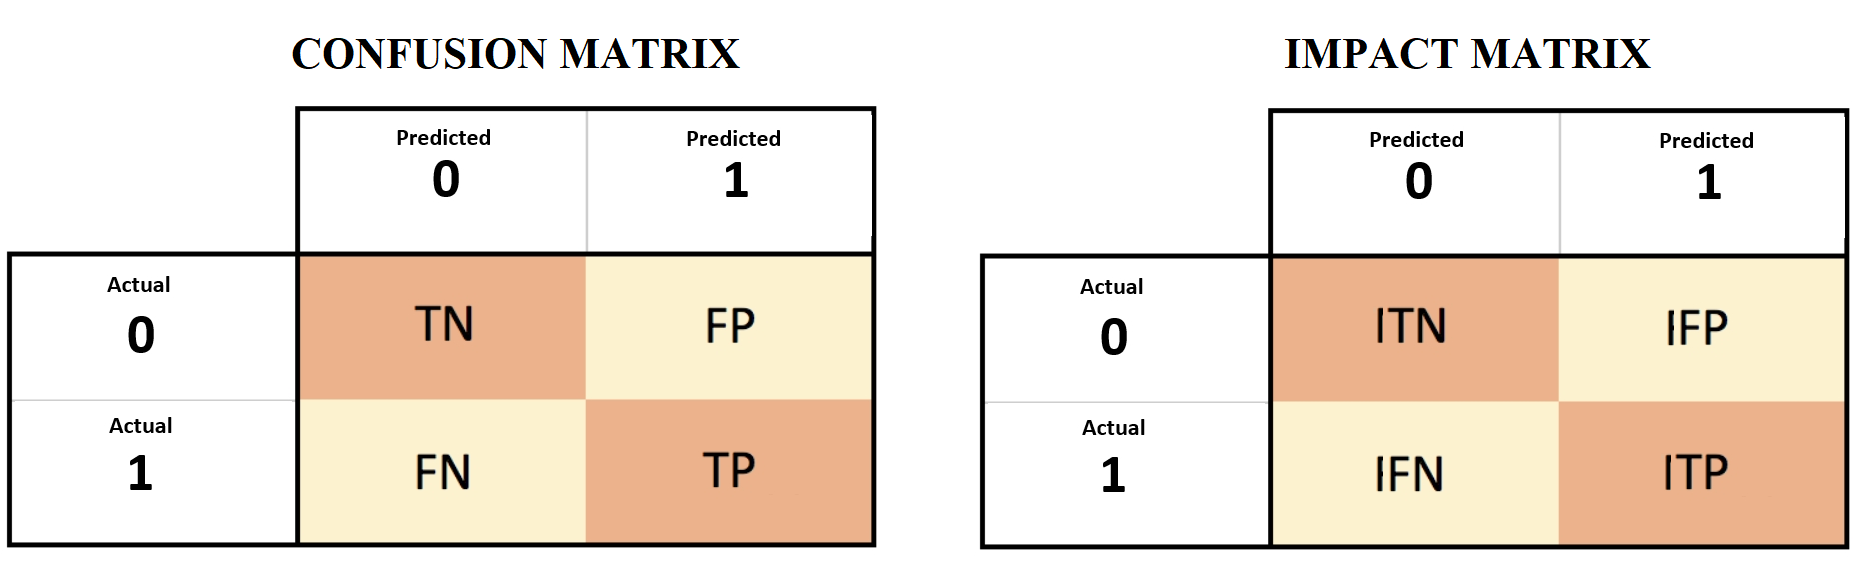

In [45]:
from IPython import display
display.Image("../../01_Documents/00_Images/confusion_and_impact_matrices.png")

- Confusion matrix:
    - Confusion matrices represent counts from predicted and actual values. The output “TN” stands for True Negative which shows the number of negative examples classified accurately. Similarly, “TP” stands for True Positive which indicates the number of positive examples classified accurately. The term “FP” shows False Positive value, i.e., the number of actual negative examples classified as positive; and “FN” means a False Negative value which is the number of actual positive examples classified as negative.

- Impact matrix:
    - It accounts for the economic impact represented by each of the components of the confusion matrix. The output “ITN” stands for Impact of True Negative which shows the economic impact of not to carry out any commercial actions on those leads that were not going to buy the product. Similarly, “ITP” stands for Impact of True Positive which indicates the net profit obtained from commercial actions on customers who end up buying the course. The term “IFP” shows Impact of False Positive value, i.e., the opportunity cost of not having carried out commercial actions on leads who would have become customers. Finally, “IFN” means a Impact of False Negative value which represent the economic cost of commercial actions carried out on a lead that finally does not buy the company's product.
    
By calculating the confusion matrix multiplying it by the economic impact matrix for each of the possible values of the discrimination threshold it will be possible to assess which discrimination threshold maximises the resulting function and thus company's ROI.

## Defining economic impact matrix

Each of the components of the impact matrix will then be assessed according to the economic data provided by the company:
- ITN = 0 \$
- IFP = -3.25 \$ 
- IFN = -49.99 \$
- ITP =  49.99 - 3.25 = 46.74 \$

In [15]:
itn, ifp, ifn, itp = 0, -ltc_avg_cost, -product_price, product_price - ltc_avg_cost

## Calculating expected value for each discrimination threshold

Defining a function that goes through all the values of discrimination thresholds and calculates the expected value by multiplying the confusion matrix of each discrimination threshold by the impact matrix.

In [11]:
def disc_threshold_max_roi(y_true,y_scoring, itn, ifp, ifn, itp, step_size = 0.01, plot = True, import_packages = True): 
    #Importations
    if import_packages==True:
        from sklearn.metrics import confusion_matrix
        import seaborn as sns
        import matplotlib.pyplot as plt
        %matplotlib inline

    #Expected value function
    def expected_value(conf_matrix):
        tn, fp, fn, tp = conf_matrix.ravel()
        ev = (tn*itn) + (fp*ifp) + (fn*ifn) + (tp*itp)
        return(ev)
    
    #Expected value for each discrimination threshold
    ev_list = []
    for disc_threshold in np.arange(0,1,step_size):
        pred = np.where(y_scoring > disc_threshold,1,0)
        cm = confusion_matrix(y_true,pred)
        ev_list.append(tuple([disc_threshold,expected_value(cm)]))

    df_temp = pd.DataFrame(ev_list, columns=['discrimination_threshold','expected_value'])
    
    #Optimal values
    optimal_disc_threshold = df_temp.iloc[df_temp.expected_value.idxmax(),0]
    ev_max = df_temp.iloc[df_temp.expected_value.idxmax(),1]
    
    if plot==True:
        print('Optimal values:')
        print(f'\tDiscrimination Threshold: {optimal_disc_threshold}')
        print(f'\tExpected value: {ev_max}')
        positives_ev = df_temp[df_temp.expected_value>0]
        plt.figure(figsize=(16,10))
        sns.lineplot(data=positives_ev, x='discrimination_threshold', y='expected_value')
        plt.xticks(positives_ev.discrimination_threshold, fontsize=10, rotation=90)
        plt.yticks(positives_ev.expected_value, fontsize=10);
    else:
        return(optimal_disc_threshold)

## Finding discrimination threshold that maximises expected value 

Optimal values:
	Discrimination Threshold: 0.07
	Expected value: 35358.31


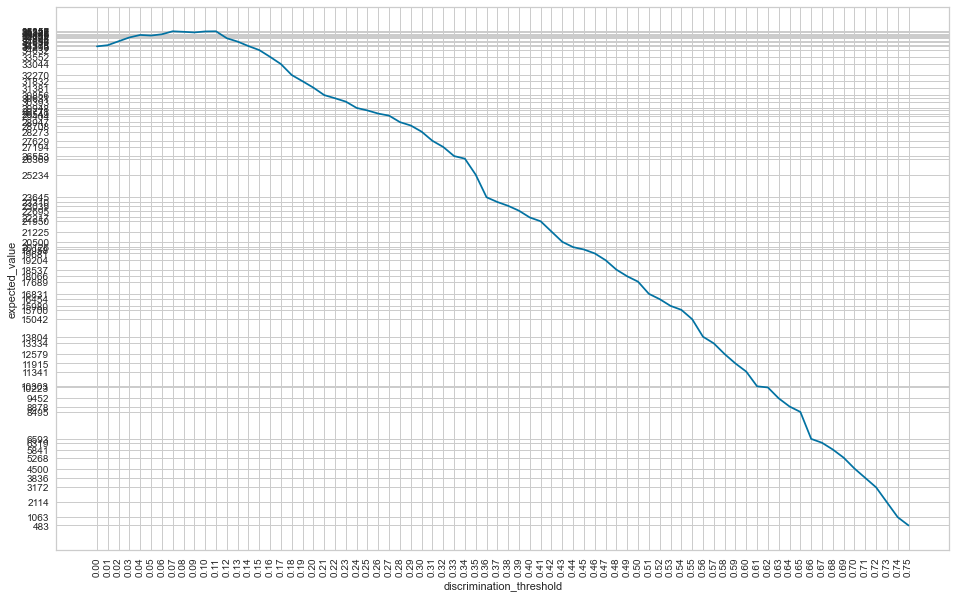

In [71]:
disc_threshold_max_roi(val_y, pred_lr, itn, ifp, ifn, itp, plot=True)

In [21]:
optimal_disc_threshold = disc_threshold_max_roi(val_y, pred_lr, itn, ifp, ifn, itp, plot=False)

Once the model is in production, it will provide the sales team with the following information:

In [24]:
model_results = pd.DataFrame({'lead_score':pred_lr,
                             'manage_lead':np.where(pred_lr>optimal_disc_threshold, 'Yes', 'No')})
model_results

,lead_score,manage_lead
0,0.03,No
1,0.21,Yes
2,0.84,Yes
3,0.22,Yes
4,0.29,Yes
...,...,...
2133,0.99,Yes
2134,0.09,Yes
2135,0.06,No
2136,0.39,Yes


# TESTING MODEL POTENTIAL IMPACT

This section analyses the potential improvements (train-test dataset) that the company could obtain from the application of the machine learning model.

## KPI - Conversion rate

### As is

Conversion rate without applying the developed machine learning model:

In [73]:
val_y.mean()

0.3891487371375117

### To be

Conversion rate managing only those leads that the model identifies as profitable customers:

In [71]:
pd.concat([model_results,val_y.reset_index(drop=True)],axis=1) \
   [pd.concat([model_results,val_y.reset_index(drop=True)],axis=1).lead_score>optimal_disc_threshold] \
   ['converted'].mean()

0.5018248175182481

- Conversion rate increased by 11.3%

## KPI - Sales team workload

### As is

Number of leads to be managed without applying the developed model:

In [80]:
val_y.shape[0]

2138

### To be

Number of leads selected by the algorithm to be managed:

In [81]:
pd.concat([model_results,val_y.reset_index(drop=True)],axis=1) \
   [pd.concat([model_results,val_y.reset_index(drop=True)],axis=1).lead_score>optimal_disc_threshold].shape[0]

1644

- Number of leads to be handled by the sales team reduced by 23.1%.

## KPIs - Sales profit and Lost investment in not converted lead management

### As is

In [84]:
val_y.value_counts()

0    1306
1     832
Name: converted, dtype: int64

Profit from product sales:

In [94]:
val_y.value_counts()[1]*(product_price-ltc_avg_cost)

38887.68

Amount lost in managing leads that ultimately did not buy the product:

In [91]:
val_y.value_counts()[0]*ltc_avg_cost

4244.5

Sales profit: 34643.18 \$

### To be

Numer of leads converted and not converted:

In [86]:
pd.concat([model_results,val_y.reset_index(drop=True)],axis=1) \
   [pd.concat([model_results,val_y.reset_index(drop=True)],axis=1).lead_score>optimal_disc_threshold] \
   ['converted'].value_counts().sort_index()

0    819
1    825
Name: converted, dtype: int64

Profit from product sales:

In [93]:
pd.concat([model_results,val_y.reset_index(drop=True)],axis=1) \
   [pd.concat([model_results,val_y.reset_index(drop=True)],axis=1).lead_score>optimal_disc_threshold] \
   ['converted'].value_counts()[1] * (product_price-ltc_avg_cost)

38560.5

Amount lost in managing leads that ultimately did not buy the product:

In [92]:
pd.concat([model_results,val_y.reset_index(drop=True)],axis=1) \
   [pd.concat([model_results,val_y.reset_index(drop=True)],axis=1).lead_score>optimal_disc_threshold] \
   ['converted'].value_counts()[0] * ltc_avg_cost

2661.75

In [100]:
2661.75*100/4244.5

62.710566615620216

- Sales profit: 35898.75 \$ (increased by 3.62%)
- 37.3% reduction in the amount lost due to the management of low quality leads.

## Conclusions

By applying the developed machine learning predictive model, the company would be able to increase its sales profit by 3.62% with a 23.1% lower commercial effort.

*Note: The validity of these results should be checked on the validation data reserved at the initial stage of the project.*